In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import os
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
import datetime
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, recall_score, precision_score

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler

/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/iuro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be r

# Pré processamento

In [2]:
df = pd.read_csv("./weather.csv")
date = df['Date']    
df = df.drop(['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM'],axis=1) #remove id column
df = df.dropna()

sin = []
cos = []
for i, date in enumerate(df['Date']):
    d = date
    year, month, day = map(int, d.split('-'))
    d = datetime.date(year, month, day)
    day_number = d.timetuple().tm_yday
    sin.append(np.sin(math.pi*2*(day_number - 1)/364)) 
    cos.append(np.cos(math.pi*2*(day_number - 1)/364)) 
df['Date_cos'] = cos
df['Date_sin'] = sin    

wind_directions = {
    'N': 90.0, 
    'NNE': (90 + 45) / 2,
    'NE': 45.0,
    'ENE': (45) / 2,
    'E': 0.0,
    'ESE': (0 - 45) / 2,
    'SE': -45.0,
    'SSE': (-90 - 45) / 2,
    'S': -90.0,
    'SSW': (-90 - 135) / 2,
    'SW': -135.0,
    'WSW': (180 - 135) / 2,
    'W': 180.0,
    'WNW': (180 + 135) / 2,
    'NW': 135.0,
    'NNW': (135 + 90) / 2
}

df['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace = True)
df['RainToday'].replace({'Yes': 1, 'No': 0}, inplace = True)

def log(x):
        return np.log(x+0.1)

df['Rainfall'] = df['Rainfall'].apply(log) 

for column in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df[column].replace(wind_directions, inplace = True)
    df[column + '_cos'] = df[column].apply(np.cos) 
    df[column + '_sin'] = df[column].apply(np.sin)
    df.drop([column], axis=1, inplace=True)
   

df_autocorr = df.copy()

df = df.drop(['Date'],axis=1) #remove unused date column


for col in df:
    if col in ["Humidity3pm","Humidity9am","MinTemp","MaxTemp"]:
        df[col+'-1'] = df[col].shift(periods=1, axis=0)
        df[col+'-2'] = df[col].shift(periods=2, axis=0)

df = df.iloc[2:]
df = df.reset_index(drop=True)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_cos,WindDir3pm_sin,MinTemp-1,MinTemp-2,MaxTemp-1,MaxTemp-2,Humidity9am-1,Humidity9am-2,Humidity3pm-1,Humidity3pm-2
0,12.9,25.7,-2.302585,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,...,-0.873305,-0.487175,7.4,13.4,25.1,22.9,44.0,71.0,25.0,22.0
1,9.2,28.0,-2.302585,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,...,1.000000,0.000000,12.9,7.4,25.7,25.1,38.0,44.0,30.0,25.0
2,17.5,32.3,0.095310,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,...,-0.996088,0.088369,9.2,12.9,28.0,25.7,45.0,38.0,16.0,30.0
3,14.6,29.7,-1.203973,56.0,19.0,24.0,55.0,23.0,1009.2,1005.4,...,-0.598460,-0.801153,17.5,9.2,32.3,28.0,82.0,45.0,33.0,16.0
4,14.3,25.0,-2.302585,50.0,20.0,24.0,49.0,19.0,1009.6,1008.2,...,-0.598460,-0.801153,14.6,17.5,29.7,32.3,55.0,82.0,23.0,33.0


## Remoção de outliers

In [3]:
#Get mean distances

import time
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_chunked

X = df.drop(['RainToday', 'RainTomorrow'],axis=1)
mean = []
chunks = pairwise_distances_chunked(X)
for chunk in tqdm(chunks):
    mean.extend(chunk.mean(1))

96it [03:37,  2.27s/it]


### Gráfico de distâncias ordenadas

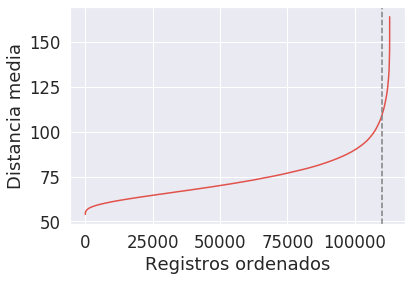

In [5]:
from ipywidgets import interact
import ipywidgets as widgets

sorted_mean = mean.copy()
sorted_mean.sort()

plt.plot(sorted_mean)
plt.xlabel('Registros ordenados')
plt.ylabel('Distancia media')
plt.axvline(x=110000, color="grey", linestyle="--")
plt.show()
    
    
# interact(plot, x=widgets.IntSlider(min=0, max=len(sorted_mean), step=1000, value=110000))

In [6]:
#Create dataframe without the outliers

df_distances = pd.DataFrame(mean, columns=["mean"])
df_distances = df_distances.sort_values(by=["mean"])
df_distances = df_distances.iloc[110000:]
df_distances.tail()

,mean
112029,151.242023
106475,151.770824
85848,153.097959
86533,161.331376
14762,164.165389


In [7]:
df = df.drop(df_distances.index.values.tolist())

## Gráficos de autocorrelação

Os dois registros anteriores das vairáveis que apresentaram maior autocorrelação foram usados como variáveis de entrada do modelo

In [8]:
df_autocorr.index = pd.Index(df_autocorr['Date'].values.squeeze())
df_autocorr = df_autocorr.drop(['Date'], axis=1)

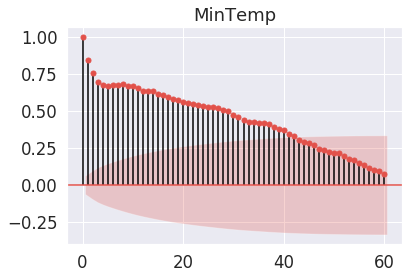

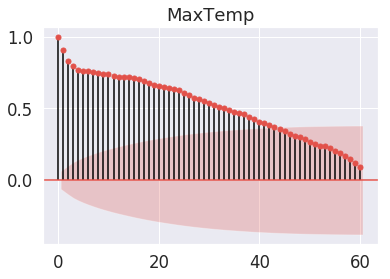

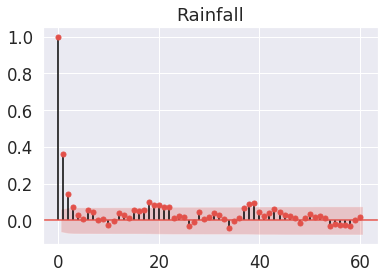

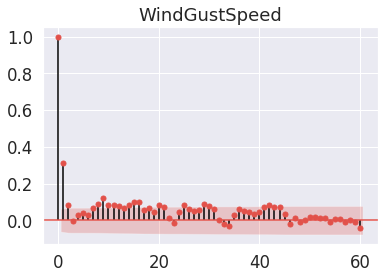

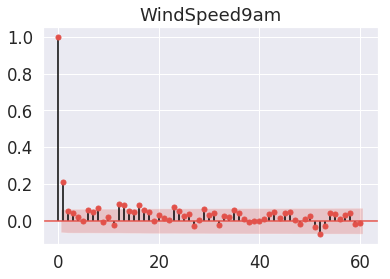

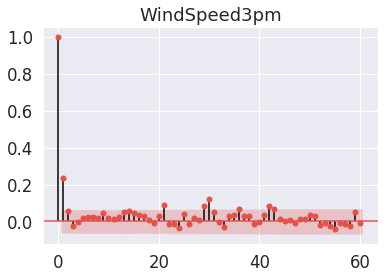

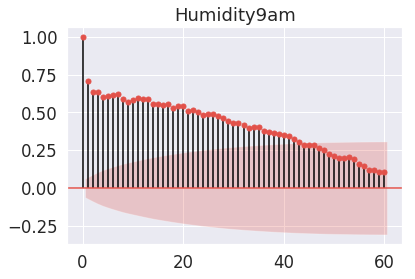

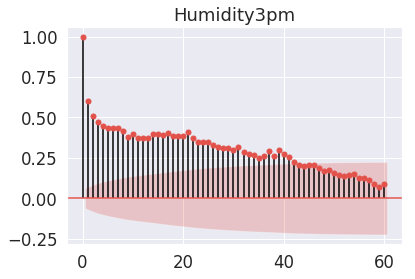

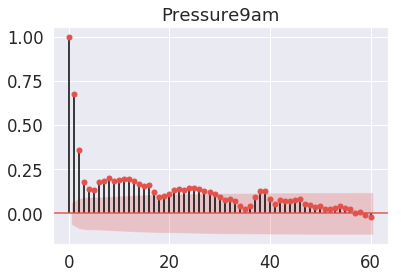

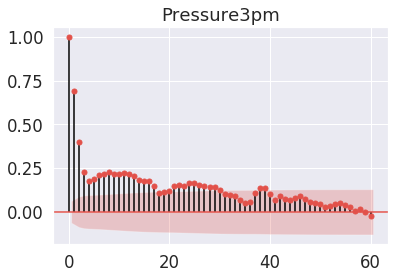

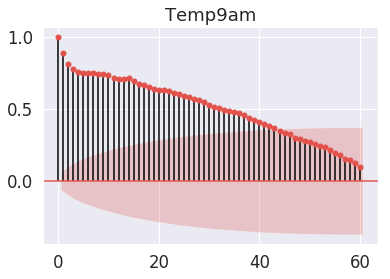

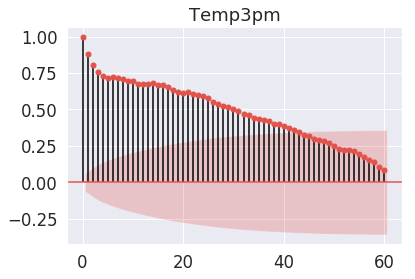

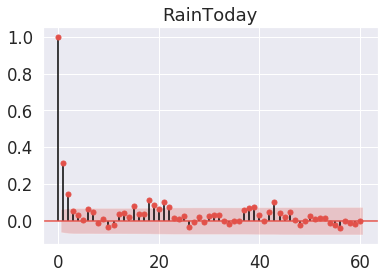

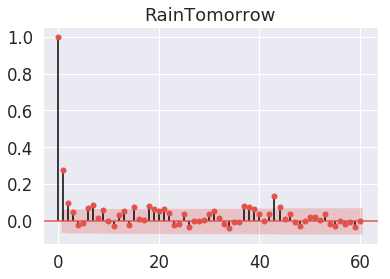

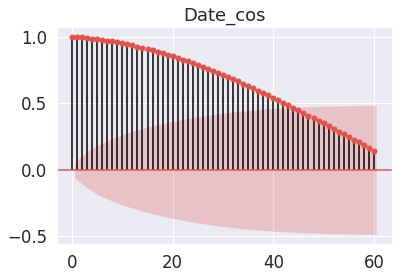

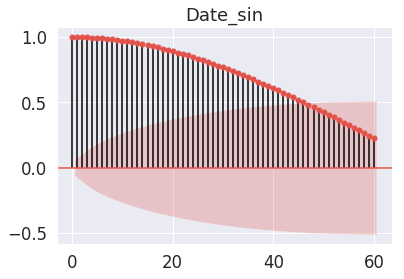

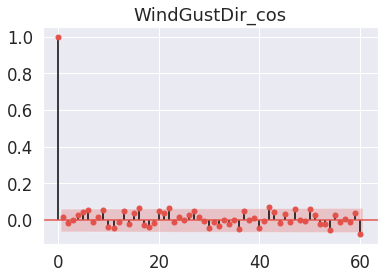

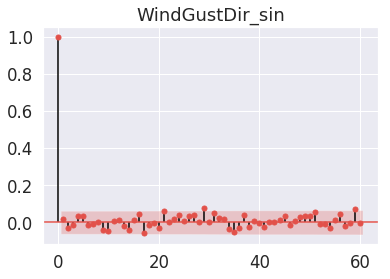

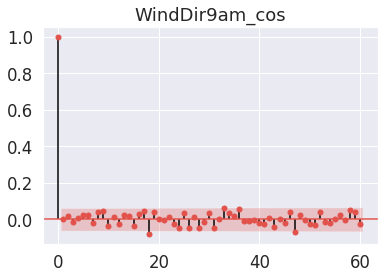

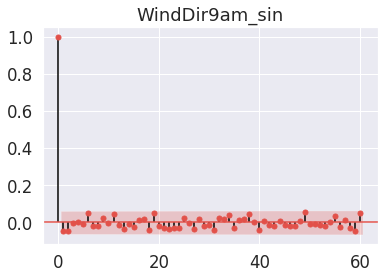

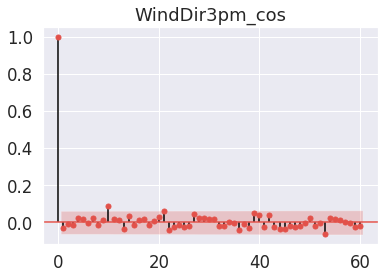

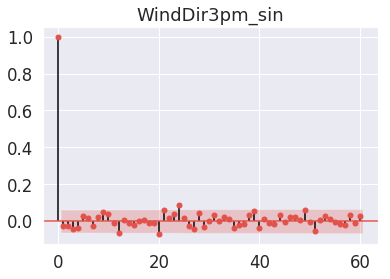

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

for column in df_autocorr:
    sm.graphics.tsa.plot_acf(df_autocorr.drop(df_autocorr.columns.difference([column]), 1)[:1000].values.squeeze(), lags=60)
    plt.title(column)
    plt.show()

## Análise de Componentes Principais
Removemos o número de componentes principais que nos permita manter 98% da variância total dos dados

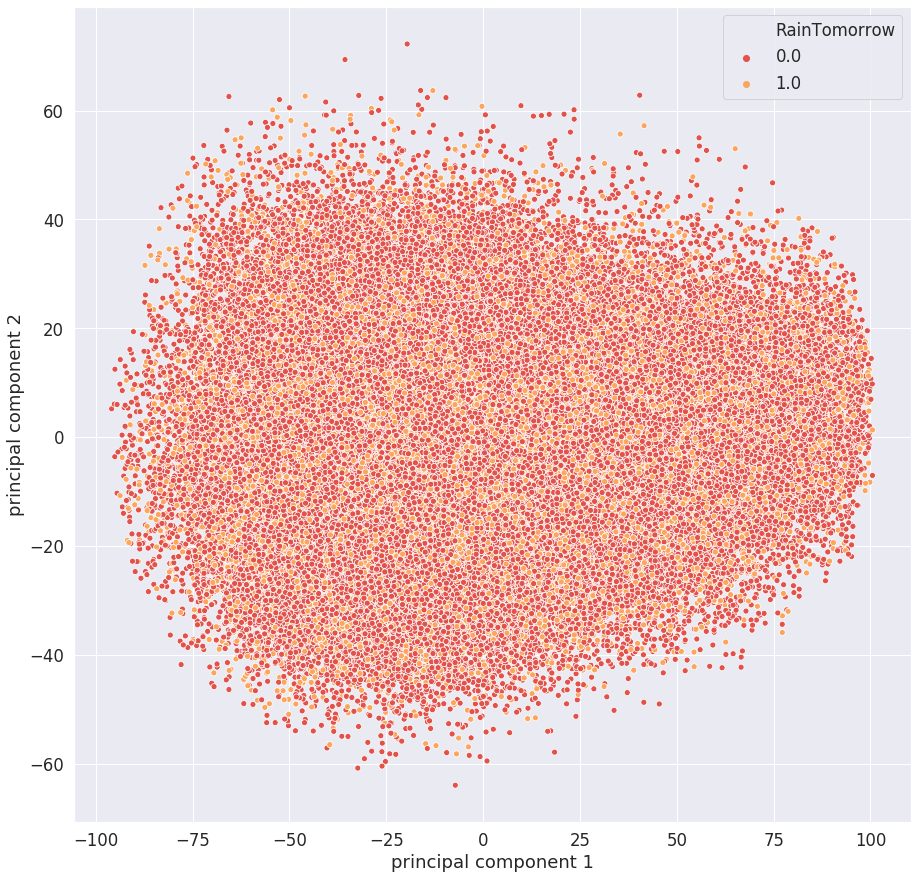

In [19]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=2)
pca.fit(X)
principalComponents = pca.transform(X)
principalData = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

target = df['RainTomorrow'] 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=principalData, x='principal component 1', y='principal component 2',hue=target, ax=ax, legend='full')

<BarContainer object of 11 artists>

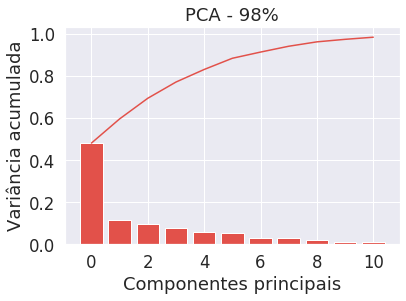

In [8]:
X = df.drop(['RainTomorrow', 'RainToday'], axis=1)

pca = PCA(n_components=0.98)
pca.fit(X)
X_pca = pca.transform(X)

#plot explained_variance
plt.title("PCA - 98%")
plt.ylabel('Variância acumulada')
plt.xlabel('Componentes principais')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
y_pos = np.arange(len(pca.explained_variance_ratio_))
plt.bar(y_pos, pca.explained_variance_ratio_)

# Modelos Lineares

In [23]:
# X = df.drop(['RainTomorrow', 'RainToday'], axis=1)
X = X_pca
y = df['RainTomorrow']

#Balancing classes with undersampling
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split training data to enable model verification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=26)

print("Shape")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print ("X_test:", X_test.shape)

Shape
X_train: (39529, 11)
y_train: (39529,)
X_test: (9883, 11)


## Resultados

In [20]:
Cs = [0.001, 0.1, 1.0, 10.0]

models = [
    {
        'model': LogisticRegression(),
        'name': 'LogisticRegression',
        'parameters': [{
            'penalty': ['l1','l2', 'elasticnet', 'none'],
            'C': Cs,
            'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }]
    },
#     {
#         'model': RandomForestClassifier(),
#         'name': 'RandomForest',
#         'parameters': [{
#             'bootstrap': [True],
#             'max_depth': [80, 90, 100, 110],
#             'max_features': [2, 3],
#             'min_samples_leaf': [3, 4, 5],
#             'min_samples_split': [8, 10, 12],
#             'n_estimators': [100, 200, 300, 1000]
#         }]
#     },
#     {
#         'model': DecisionTreeClassifier(),
#         'name': 'DecisionTree',
#         'parameters': [{
#             'max_depth': [1, 10, 20],
#             'min_samples_leaf': [3, 4, 5],
#             'min_samples_split': [8, 10, 12],
#         }]
#     },
#     {
#         'model': KNeighborsClassifier(),
#         'name': 'KNeighbors',
#         'parameters': [{
#             'n_neighbors': [1, 10, 20, 30],
#             'p': [1,2,3, 4, 5],
#         }]
#     },
#     {
#         'model': GaussianNB(),
#         'name': 'GaussianNaiveBayes',
#         'parameters': []
#     },
#     {
#         'model': LinearRegression(),
#         'name': 'LinearRegression',
#         'parameters': []
#     },
#     {
#         'model': QuadraticDiscriminantAnalysis(),
#         'name': 'QDA',
#         'parameters': []
#     },
]



In [23]:
for model in models:
    clf = GridSearchCV(model['model'], model['parameters'], cv=10, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_train, y_train)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca98.csv'.format(model['name']), index=False)

{'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'name': 'LogisticRegression', 'parameters': [{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.001, 0.1, 1.0, 10.0], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]}
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 777 out of 800 | elapsed:   12.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   13.0s finished


Gaussian Naive Bayes:
	Precision: 0.7530268768004061
	Recall: 0.7502223034723539
	F1-Score: 0.749507040011707
	Accuracy: 0.7502228532850748



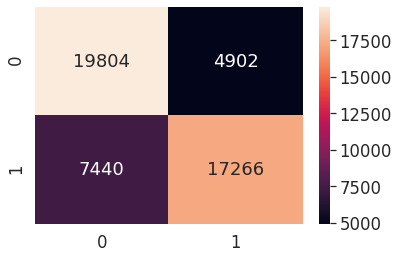

Quadratic Discriminant Analysis:
	Precision: 0.7575143587670554
	Recall: 0.7526303460559409
	F1-Score: 0.7513930993441928
	Accuracy: 0.7526307545294723



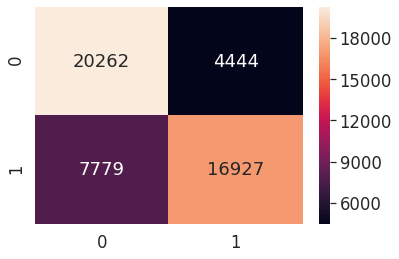

In [35]:
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

models = [
#     LinearRegression(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = [
#     'Linear Classifier',
    'Gaussian Naive Bayes',
    'Quadratic Discriminant Analysis',
]

for model, name in zip(models, names):
    scores = cross_validate(model, X_resampled, y_resampled, cv=5, scoring=['precision_macro','recall_macro','accuracy','f1_macro'])
    print("{}:\n\tPrecision: {}\n\tRecall: {}\n\tF1-Score: {}\n\tAccuracy: {}\n".format(name,np.mean(scores['test_precision_macro']),np.mean(scores['test_recall_macro']),np.mean(scores['test_f1_macro']), np.mean(scores['test_accuracy'])))
  
    y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=5)
    confusion = confusion_matrix(y_resampled, y_pred)
    
    p = sns.heatmap(confusion, annot=True, fmt="d")
    plt.show()

# Modelos não lineares

## SVM

In [10]:
gammas = ['auto', 'scale'] + [ 1.0, 10.0, 100.0, 1000.0]
Cs = [1.0, 10.0, 100.0, 1000.0]
# Cs = [1000.0]

parameters = [
    {
        'kernel': ['rbf'],
        'gamma': gammas,
        'C': Cs
    },
#     {
#         'kernel': ['linear'],
#         'C': Cs
#     },
#     {
#         'kernel': ['sigmoid'],
#         'gamma': [1, 0.5, 0.01],
#         'C': Cs
#     },
#     {
#         'kernel': ['poly'],
#         'gamma': ['scale'],
#         'degree': [2, 3, 4, 5],
#         'C': Cs
#     }
]

In [13]:
for param in parameters:
    print(param)
    clf = GridSearchCV(SVC(), param, cv=60, verbose=1, return_train_score=True, n_jobs=-1)
    clf.fit(X_train, y_train)

    results = pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score')
    results.to_csv('results_{0}_cv10_pca10.csv'.format(param['kernel'][0]), index=False)

{'kernel': ['rbf'], 'gamma': ['auto', 'scale', 1.0, 10.0, 100.0, 1000.0], 'C': [1.0, 10.0, 100.0, 1000.0]}
Fitting 60 folds for each of 24 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

### Melhor modelo: $\gamma = scale$ , $C = 1000$, $kernel: RBF$  